In [1]:
import torch
import torch.nn as nn

import torchvision

import numpy as np
import matplotlib.pyplot as plt

from math import sqrt, ceil
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class SquashTransform:
    def __call__(self, inputs):
        return 2 * inputs - 1
    
data_train = torchvision.datasets.ImageFolder(
    '../data/cifar10_attack_labeled_vgg/',
    transform=torchvision.transforms.Compose([
        Resize((32,32)),
        ToTensor()
    ])
)

In [4]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

num_steps = (len(data_train) // BATCH_SIZE) - 1
len(data_train), num_steps

(5000, 311)

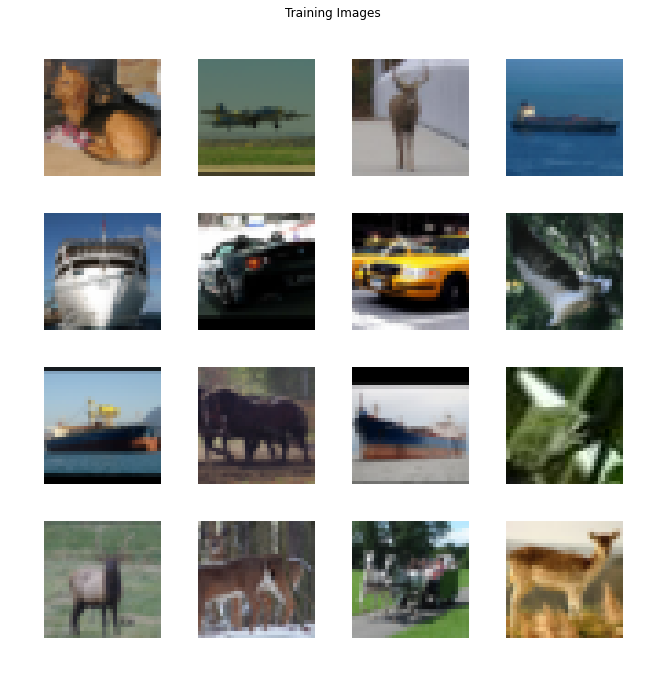

In [5]:
real_batch = next(iter(train_loader))

plt.figure(figsize=(22, 12))
plt.axis('off')
plt.title('Training Images')

plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device),
            padding=10,
            normalize=True,
            pad_value=1,
            nrow=int(sqrt(BATCH_SIZE))
        ).cpu(),
        (1, 2, 0)
    )
);

In [6]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Size of labels dimension
nl = 10

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        x = torch.cat((input, label), dim=1).unsqueeze(2).unsqueeze(3)
        return self.main(x)

In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
                 
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2)
        )

        self.clf = nn.Sequential(
            nn.Linear(
                in_features=ndf * 4 * 4 * 4,
                out_features=nl,
                bias=True
            ),
            torch.nn.Softmax(dim=1)
        )

        self.police = torch.nn.Sequential(
            torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        features = self.main(input)
        valid = self.police(features).view(-1, 1)
        clf = self.clf(features.view(features.shape[0], -1))
        return valid, clf

In [46]:
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [47]:
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=0.0001,
    betas=(0.5, 0.999)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=0.0001,
    betas=(0.5, 0.999)
)

In [48]:
def encodeOneHot(labels):
    ret = torch.FloatTensor(labels.shape[0], nl)
    ret.zero_()
    ret.scatter_(dim=1, index=labels.view(-1, 1), value=1)
    return ret

In [49]:
fixed_noise = torch.randn(
    nl, nz
).to(device)


real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

c1 = torch.nn.BCELoss()

In [50]:
def c2(input, target):

    _, labels = target.max(dim=1)

    return torch.nn.CrossEntropyLoss()(input, labels)

In [51]:
fixed_conditions = encodeOneHot(
    torch.randint(
        0,
        nl,
        (nl, 1)
    )
).to(device)

In [52]:
def trainD(images, labels):
    real_images = images.to(device)
    real_conditions = encodeOneHot(labels).to(device)

    fake_conditions = encodeOneHot(
        torch.randint(
            0,
            nl,
            (BATCH_SIZE, 1)
        )
    ).to(device)

    fake_images = netG(
        torch.randn(
            BATCH_SIZE, nz
        ).to(device),
        fake_conditions  
    )

    optimizerD.zero_grad()

    real_valid, real_clf = netD(real_images)
    fake_valid, fake_clf = netD(fake_images)

    d_loss = c1(real_valid, real_labels) + c2(real_clf, real_conditions) \
        + c1(fake_valid, fake_labels) + c2(fake_clf, fake_conditions)

    d_loss.backward()

    optimizerD.step()

    return d_loss

In [53]:
def trainG(labels):
    conditions = encodeOneHot(labels).to(device)

    z1 = torch.randn(BATCH_SIZE, nz).to(device)
    z2 = torch.randn(BATCH_SIZE, nz).to(device)

    netG.zero_grad()

    images1 = netG(z1, conditions)
    images2 = netG(z2, conditions)
    
    outputs1, clf1 = netD(images1)
    outputs2, clf2 = netD(images2)

    mode_loss = torch.mean(torch.abs(images2 - images1)) \
                / torch.mean(torch.abs(z2 - z1))
    
    image_loss = c1(outputs1, real_labels) + c1(outputs2, real_labels)
    clf_loss = c2(clf1, conditions) + c2(clf2, conditions)

    loss = image_loss + clf_loss + (.5 * mode_loss)

    loss.backward()

    optimizerG.step()

    return loss

In [54]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()

In [55]:
path_netG = '../models/adversary/aux_dcgan_netG.pytorch'
path_netD = '../models/adversary/aux_dcgan_netD.pytorch'
path_optG = '../models/adversary/aux_dcgan_optG.pytorch'
path_optD = '../models/adversary/aux_dcgan_optD.pytorch'

In [40]:
import os

if os.path.exists(path_netG):
    print("Loading NetG")
    netG.load_state_dict(torch.load(path_netG))

if os.path.exists(path_netD):
    print("Loading NetD")
    netD.load_state_dict(torch.load(path_netD))

if os.path.exists(path_optG):
    print("Loading OptG")
    optimizerG.load_state_dict(torch.load(path_optG))

if os.path.exists(path_optD):
    print("Loading OptD")
    optimizerD.load_state_dict(torch.load(path_optD))

In [60]:
for epoch in range(1001, 5001):
    d_loss = 0
    g_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        if i == num_steps:
            break

        for k in range(1):
             d_loss += trainD(images, labels)

        g_loss = trainG(labels)

    
    if epoch % 50 == 0:
        # Tensorboards Logging
        tb_writer.add_scalar(
            'DCGANVGG/D Loss',
            d_loss / num_steps / 1,
            epoch
        )

        tb_writer.add_scalar(
            'DCGANVGG/G Loss',
            g_loss / num_steps,
            epoch
        )

        generated = netG(
            fixed_noise,
            fixed_conditions
        ).detach().cpu().view(
            -1,
            3,
            32,
            32
        )

        grid = torchvision.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'DCGANVGG/Output',
            grid,
            epoch
        )
        
        
        # Save checkpoint
        torch.save(netG.state_dict(), path_netG)
        torch.save(netD.state_dict(), path_netD)
        torch.save(optimizerG.state_dict(), path_optG)
        torch.save(optimizerD.state_dict(), path_optD)

In [57]:
fixed_conditions

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')

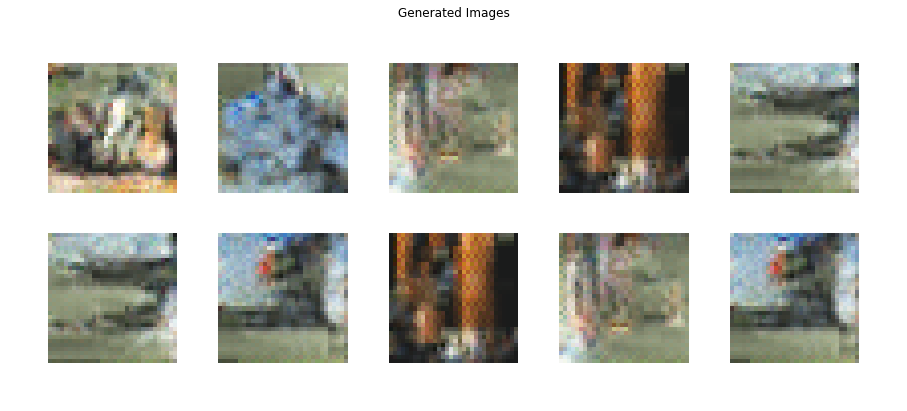

In [61]:
generated = netG(fixed_noise, fixed_conditions).detach().cpu().view(-1, 3, 32, 32)

grid = torchvision.utils.make_grid(
    generated,
    padding=10,
    pad_value=1,
    normalize=True,
    nrow=5
)

fig = plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);

In [62]:
torch.save(netG, '../models/adversary/g_cifar10_500img_modeseeking.pth')
torch.save(netD, '../models/adversary/d_cifar10_500img_modeseeking.pth')